In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Add file names to individual DataFrames
df_k['File'] = df_match.Kinect
df_z['File'] = df_match.Zeno

## Visual Results

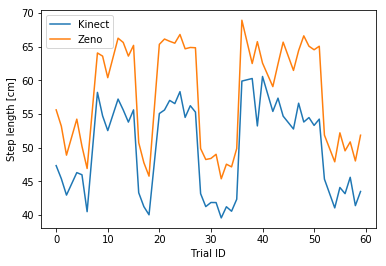

In [3]:
%matplotlib inline
plt.plot(df_k['step_length'])
plt.plot(df_z['step_length'])

plt.xlabel('Trial ID')
plt.ylabel('Step length [cm]')

plt.legend(['Kinect', 'Zeno'])
plt.show()

In [4]:
abs(df_k.step_length - df_z.step_length).sort_values(ascending=False).head()

48    12.792880
39    12.512941
50    11.233277
44    10.987218
51    10.822952
Name: step_length, dtype: float64

In [5]:
abs(df_k.step_length - df_z.step_length).mean()

7.80722475507931

In [6]:
df_z.loc[23]

absolute_step_length                             65.574
step_length                                      65.508
stride_length                                   130.999
stride_time                                       1.144
stride_velocity                                 114.536
stride_width                                     -0.497
File                    B_2014-12-16_P005_Post_tc_dtacb
Name: 23, dtype: object

In [7]:
df_k.loc[23]

absolute_step_length                     57.0156
step_length                               56.536
stride_length                            113.129
stride_time                             0.436667
stride_velocity                          122.909
stride_width                             6.98247
File                    2014-12-16_P005_Post_004
Name: 23, dtype: object

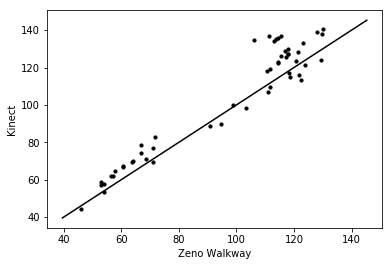

In [8]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_velocity'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

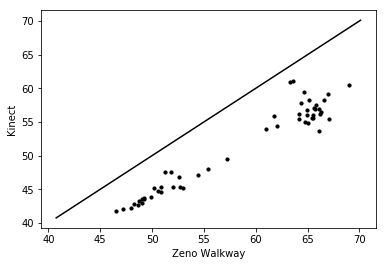

In [9]:
metric = 'absolute_step_length'

pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

In [10]:

def apply_to_columns(df_1, df_2, func):

    df_numeric = df_1.select_dtypes(include='number')

    results_dict = {k: {} for k in df_numeric}

    for col in df_numeric:
        
        results_dict[col] = func(df_1[col], df_2[col])

    return results_dict

In [11]:
d = {}
d['Pearson'] = apply_to_columns(df_z, df_k, lambda a, b: pearsonr(a, b)[0])
d['Spearman'] = apply_to_columns(df_z, df_k, lambda a, b: spearmanr(a, b)[0])

d['Abs rel error'] = apply_to_columns(df_z, df_k, lambda a, b: st.relative_error(a, b, absolute=True).mean())

d['Bias'] = apply_to_columns(df_z, df_k, lambda a, b: st.relative_difference(a, b).mean())


df_results = pd.DataFrame(d).T

In [12]:
df_results

,absolute_step_length,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.965873,0.959582,0.967561,0.926200,0.961662,0.912833
Spearman,0.868455,0.864253,0.886622,0.693634,0.832665,0.798002
Abs rel error,0.139452,0.157573,0.164006,1.486741,0.076781,0.414782
Bias,0.129867,0.145419,0.151004,0.847419,-0.062615,-0.751253


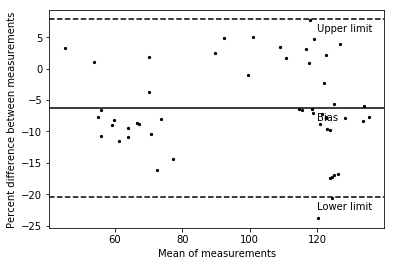

In [13]:
import modules.plotting as pl

metric = 'stride_velocity'

means, diffs = st.BlandAltman.differences(df_z[metric], df_k[metric], percent=True)

bias, lower_lim, upper_lim = st.BlandAltman.limits_of_agreement(diffs)

pl.plot_bland_altman(means, diffs, bias, lower_lim, upper_lim, percent=True)